# Hierarchical scalar interpolation example

In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.append(os.path.relpath("../../src"))
import hiped as hp
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## 1) Definition of the interpolation tree
From the leaves to the root. The penalization are chosen randomly.

In [2]:
# node 1,1 (3 vertices)
f111s = hp.VertexFunction("f111s(u)", lambda u: -u**2, lambda u: -2*u)
f112s = hp.VertexFunction("f112s(u)", lambda u: u**3, lambda u: 3*u**2)
f113s = hp.VertexFunction("f113s(u)", lambda u: 0.1*u, lambda u: 0.1*np.ones(u.shape))
node11 = hp.Interpolation(hp.Domain(3), children = [f111s,f112s,f113s], label = "n11",
                          penalization = hp.Penalization("simp", 2))

# node 1,2 (2 vertices)
f121s = hp.VertexFunction("f121s(u)", lambda u: -u**2, lambda u: -2*u)
f122s = hp.VertexFunction("f122s(u)", lambda u: u**3, lambda u: 3*u**2)
node12 = hp.Interpolation(hp.Domain(2), children = [f121s,f122s], label = "n12",
                          penalization = hp.Penalization("simp", 2)) 

# node 1 (2 vertices)
node1 = hp.Interpolation(hp.Domain(2), children = [node11,node12],
                          label = "n1", penalization = hp.Penalization("simp",2)) 

# node 2 (singleton for vizualization) ; can be replaced directly by a VertexFunction
f2s = hp.VertexFunction("f2s(u)", lambda u: -0.4*u**2, lambda u: -0.8*u)
node2 = hp.Interpolation(hp.Domain(1), children = [f2s], label = "n2") 

# node 3 (singleton for vizualization)
f3s = hp.VertexFunction("f3s(u)", lambda u: 0.1*u**2, lambda u: 0.2*u)
node3 = hp.Interpolation(hp.Domain(1), children = [f3s], label = "n3") 

# node 4
f41s = hp.VertexFunction("f41s(u)", lambda u: u, lambda u: np.ones(u.shape))
f42s = hp.VertexFunction("f42s(u)", lambda u: 0.1*u**3, lambda u: 0.3*u**2)

node4 = hp.Interpolation(hp.Domain(2), children = [f41s, f42s], label = "n4",
                         penalization = hp.Penalization("simp", 2))

# Root
penalroot = hp.Penalization("zhou", 2)
interpHierarchical = hp.Interpolation(hp.Domain("tetra"), children = [node1, node2, node3, node4],
                          label = "root", penalization = penalroot)

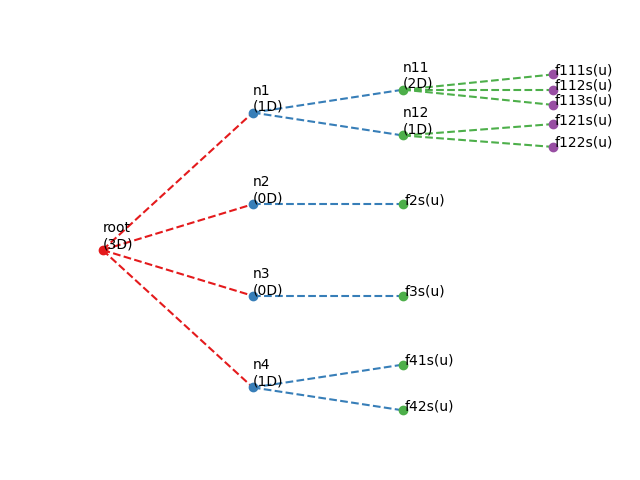

In [3]:
# Interpolation tree
plt.figure()
interpHierarchical.plotTree()

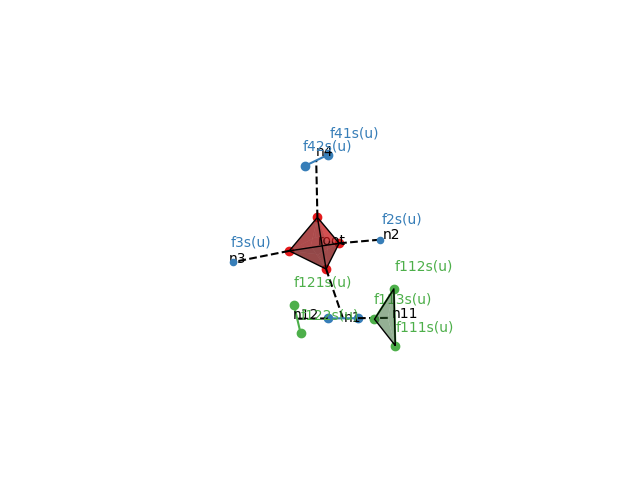

In [4]:
# 3D vizualization of the hierarchical domain
plt.figure()
interpHierarchical.plot()

## 2) Definition of the variables (coordinates $x$ and scalar field $u$)
Then the $n$ cartesian coordinates $x$ and the scalar field $u$ should be defined to evaluate the interpolation.

In [5]:
x0, u0 = [0], [0]

def f3(n, typeInit, r, u, x):
    plt.clf()
    x0[0] = interpHierarchical.setInitialVariable(n, typeInit = typeInit, radius = r) # initialization of the variables
    x0[0] = interpHierarchical.projection(x0[0]) # projection onto the domain
    interpHierarchical.plot(x0[0])
    u0[0] = np.random.rand(1,1,n)
    plt.show()

n = widgets.IntSlider(min=1, max=1000, step=1, value=100)
typeInit = [ "rand", "zero"]
r = widgets.FloatSlider(min=0, max=2, step=0.1, value=1)
plt.figure()
_ = interact(lambda n, typeInit, r : f3(n, typeInit, r, u0, x0), n=n, typeInit = typeInit, r =r )    

interactive(children=(IntSlider(value=100, description='n', max=1000, min=1), Dropdown(description='typeInit',…

## 3) Evaluation of the interpolation
### a) Interpolated values

In [6]:
x, u = x0[0].copy(), u0[0].copy()

import time
nRuns = 1000
t0 = time.time()
for i in range(nRuns):
    f = interpHierarchical.eval(x, u) # evaluate the interpolation
tv1 = time.time() - t0
print(f"Compute interpolated values in {tv1*1000:.3f} ms ({u.shape[2]} values, {nRuns} runs)")

Compute interpolated values in 901.817 ms (100 values, 1000 runs)


### b) Derivative with respect to $u$

In [7]:
nRuns = 1000
t0 = time.time()
for i in range(nRuns):
    dfdu =  interpHierarchical.evaldu(x, u) # evaluate the derivative of the interpolation w.r.t u
tv1 = time.time() - t0
print(f"Compute u-derivative in {tv1*1000:.3f} ms ({u.shape[2]} values, {nRuns} runs)")

Compute u-derivative in 699.113 ms (100 values, 1000 runs)


#### Check the Taylor expansion

We introduce small perturbations and check if the finite difference estimation of the derivative converges to the computed one.

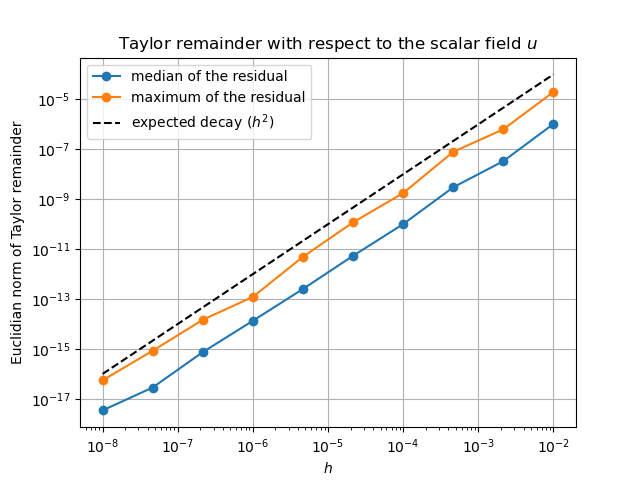

In [8]:
from hiped.utils import mult

h = np.logspace(-8,-2,10) # test for 10 different h
resU = np.zeros((10,1,u.shape[2]))


for i in range(10):
    pert = h[i]*np.random.rand(*u.shape);
    fPerturbedu = interpHierarchical.eval(x,u+pert);
    resU[i,0,:] = np.linalg.norm(fPerturbedu - (f + mult(dfdu,pert)), axis = 0)
    
maxResU = np.max(resU, axis = 2); medResU = np.median(resU, axis = 2);

plt.figure()
plt.loglog(h, medResU,'-o', label =  "median of the residual")
plt.loglog(h, maxResU,'-o', label =  "maximum of the residual")
plt.loglog(h, h**2,'k--', label =  "expected decay $(h^2)$")

plt.legend(loc = "best"); plt.grid()
plt.xlabel("$h$"); plt.ylabel("Euclidian norm of Taylor remainder")
plt.title("Taylor remainder with respect to the scalar field $u$")

plt.show()

### c) Derivative with respect to $x$

In [9]:
nRuns = 500
t0 = time.time()
for i in range(nRuns):
    dfdx =  interpHierarchical.evaldx(x, u) # evaluate the derivative of the interpolation w.r.t x
tv1 = time.time() - t0
print(f"Compute u-derivative in {tv1*1000:.3f} ms ({u.shape[2]} values, {nRuns} runs)")


Compute u-derivative in 486.991 ms (100 values, 500 runs)


#### Check the Taylor expansion

We introduce small perturbations and check if the finite difference estimation of the derivative converges to the computed one.

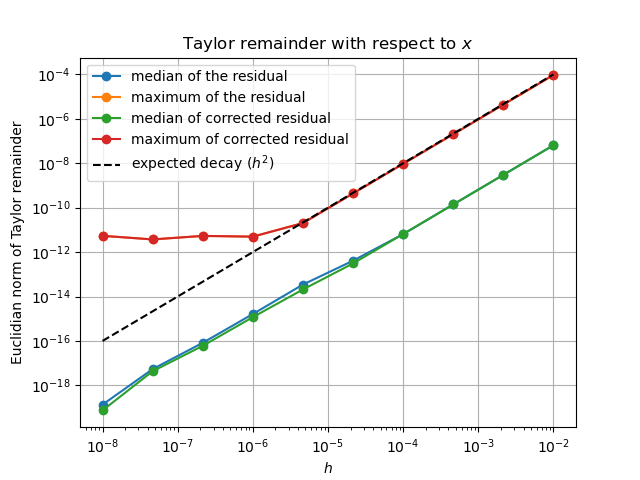

In [17]:
L = list(x.keys())
resX = np.zeros((10,len(L),u.shape[2]))
resXCorrected = np.zeros((10,len(L),u.shape[2]))

# The relative error of dfdx is quite high in the 3D domain, due to the bad conditioning when the points lie near the boundaries.
# To avoid this phenomenon, the outside points are projected slightly inside the domain. The coefficient epsProj determines 
# how deep. The deeper it is (high epsProj), the better is the computation of dfdx, but the worse is the projection.
# epsProj = 1e-5 (default value) is a good trade-off, but you can try other values.


epsProj = 1e-5
interpHierarchical = hp.Interpolation(hp.Domain("tetra", epsProj = epsProj), children = [node1, node2, node3, node4],
                          label = "root", penalization = penalroot)

x = interpHierarchical.projection(x0[0].copy())
fCorrected = interpHierarchical.eval(x, u)
dfdxCorrected = interpHierarchical.evaldx(x, u)

for i in range(10):
    for j in range(len(L)):
        xPert = x.copy()
        l=L[j]
        pert = h[i]*np.ones(x[l].shape)
        xPert[l] = x[l] + pert
        xPert = interpHierarchical.projection(xPert)
        pert = xPert[l] - x[l]
        valPerturbedx = interpHierarchical.eval(xPert,u)
        pert = pert[:,:,None].transpose(1,2,0)
        resX[i,j,:] = np.linalg.norm(valPerturbedx - (f + mult(dfdx[l], pert)), axis = 0)
        resXCorrected[i,j,:] = np.linalg.norm(valPerturbedx - (fCorrected + mult(dfdxCorrected[l], pert)), axis = 0)

maxResX = np.max(resX, axis = (1,2)); medResX = np.median(resX, axis =  (1,2));
maxResXCorrected = np.max(resXCorrected, axis = (1,2)); medResXCorrected = np.median(resXCorrected, axis =  (1,2))

plt.figure()
plt.loglog(h, medResX,'-o', label =  "median of the residual")
plt.loglog(h, maxResX,'-o', label =  "maximum of the residual")
plt.loglog(h, medResXCorrected,'-o', label =  "median of corrected residual")
plt.loglog(h, maxResXCorrected,'-o', label =  "maximum of corrected residual")
plt.loglog(h, h**2,'k--', label =  "expected decay $(h^2)$")

plt.legend(loc = "best"); plt.grid()
plt.xlabel("$h$"); plt.ylabel("Euclidian norm of Taylor remainder")
plt.title("Taylor remainder with respect to $x$")

plt.show()

### d) Speed tip

To compute several times the interpolation for different $u$  without changing the position $x$ in the domain (for example, when solving a non-linear system in $u$), one can first compute the shape functions once for all.

In [11]:
u2 = np.random.rand(1,nRuns,u.shape[2])

# naive
t0 = time.time()
for i in range(nRuns):
    interpHierarchical.eval(x, u2[:,i,:]) # value
    interpHierarchical.evaldu(x, u2[:,i,:]) # derivative w.r.t u
    interpHierarchical.evaldx(x, u2[:,i,:]) # derivative w.r.t x

tNaive = time.time() - t0
print(f"Computation time (naive version, {nRuns} runs) : {tNaive*1000:.3f} ms")

# faster
t0 = time.time()
# pre-computation of the shape functions that don't depend on u
w, dwdx = interpHierarchical.evalBasisFunction(x)
for i in range(nRuns):
    interpHierarchical.eval(x, u2[:,i,:], w) # value
    interpHierarchical.evaldu(x, u2[:,i,:], w) # derivative w.r.t u
    interpHierarchical.evaldx(x, u2[:,i,:], w, dwdx) # derivative w.r.t x
    
tOptim = time.time() - t0
print(f"Computation time (optimized version, {nRuns} runs) : {tOptim*1000:.3f} ms")

Computation time (naive version, 500 runs) : 3924.604 ms
Computation time (optimized version, 500 runs) : 892.202 ms
